In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tqdm import tqdm
import os
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization

In [2]:
IMAGES_PATH = "../../flowers"
MODEL_PATH = "../../flowers_detector.h5"

In [47]:
test_images = []
test_labels = []
test_paths = []

train_images = []
train_labels = []
train_paths = []

In [48]:
for flower in os.listdir(IMAGES_PATH):
    images_path = os.path.join(IMAGES_PATH, flower)
    # print
    t_imgs = []
    t_lbls = []
    t_paths = []
    
    for image in os.listdir(images_path):
        # print(image)
        image_path = os.path.join(images_path, image)
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        
        t_imgs.append(img)
        t_lbls.append(flower)
        t_paths.append(image_path)
        
    train_imgs, test_imgs, train_lbls, test_lbls, train_pths, test_pths = train_test_split(t_imgs, t_lbls, t_paths, test_size=0.10, random_state=42)
    
    train_images.extend(train_imgs)
    train_labels.extend(train_lbls)
    train_paths.extend(train_pths)
    
    test_images.extend(test_imgs)
    test_labels.extend(test_lbls)
    test_paths.extend(test_pths)
    

In [49]:
train_images = np.array(train_images, dtype='float32')/255.0
train_labels = np.array(train_labels)
train_paths = np.array(train_paths)

test_images = np.array(test_images, dtype='float32')/255.0
test_labels = np.array(test_labels)
test_paths = np.array(test_paths)

In [51]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [55]:
test_labels

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [7]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation='softmax'))

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, rotation_range=10)
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 96)       0

In [10]:
from tensorflow.keras.metrics import categorical_accuracy

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[categorical_accuracy])

In [11]:
batch_size = 64
epochs = 50

output = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size), epochs=epochs, validation_data=(test_images, test_labels), verbose=1, steps_per_epoch=train_images.shape[0]//batch_size)

Epoch 1/50
60/60 [==============================] - 76s 817ms/step - loss: 0.1601 - categorical_accuracy: 0.1959 - val_loss: 0.1599 - val_categorical_accuracy: 0.2322
Epoch 2/50
60/60 [==============================] - 47s 786ms/step - loss: 0.1596 - categorical_accuracy: 0.2480 - val_loss: 0.1595 - val_categorical_accuracy: 0.2529
Epoch 3/50
60/60 [==============================] - 47s 770ms/step - loss: 0.1592 - categorical_accuracy: 0.2643 - val_loss: 0.1591 - val_categorical_accuracy: 0.2506
Epoch 4/50
60/60 [==============================] - 47s 773ms/step - loss: 0.1588 - categorical_accuracy: 0.2643 - val_loss: 0.1588 - val_categorical_accuracy: 0.2552
Epoch 5/50
60/60 [==============================] - 46s 763ms/step - loss: 0.1585 - categorical_accuracy: 0.2727 - val_loss: 0.1584 - val_categorical_accuracy: 0.2759
Epoch 6/50
60/60 [==============================] - 47s 779ms/step - loss: 0.1582 - categorical_accuracy: 0.2918 - val_loss: 0.1581 - val_categorical_accuracy: 0.285

In [13]:
model.save(MODEL_PATH)


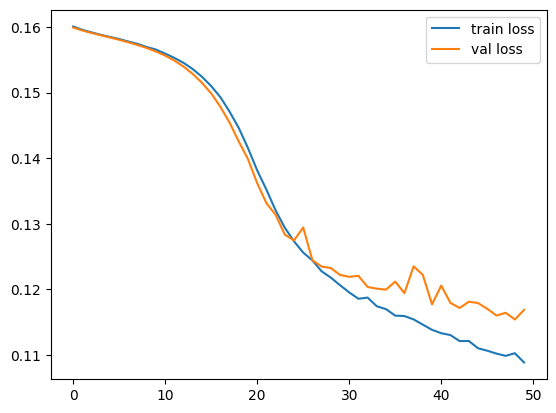

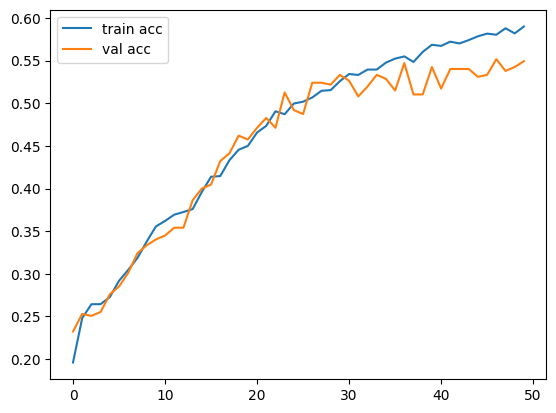

In [16]:
#loss graph
plt.plot(output.history['loss'], label='train loss')
plt.plot(output.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('loss-graph.png')
plt.show()
# accuracies
plt.plot(output.history['categorical_accuracy'], label='train acc')
plt.plot(output.history['val_categorical_accuracy'], label='val acc')
plt.legend()


plt.savefig('acc-graph.png')
plt.show()


In [71]:
y_test = [list(i).index(1) for i in test_labels]

In [62]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_val_pred = model.predict(test_images)
y_val_pred=np.argmax(y_val_pred,axis=1)
# print(test_labels, y_val_pred)
print(classification_report(y_val_pred,y_test))

14/14 [==============================] - 1s 51ms/step
              precision    recall  f1-score   support

           0       0.27      0.50      0.35        42
           1       0.71      0.54      0.61       140
           2       0.49      0.49      0.49        80
           3       0.81      0.62      0.71        96
           4       0.44      0.57      0.50        77

    accuracy                           0.55       435
   macro avg       0.55      0.54      0.53       435
weighted avg       0.60      0.55      0.56       435



In [65]:
cm = confusion_matrix(y_val_pred,y_test)

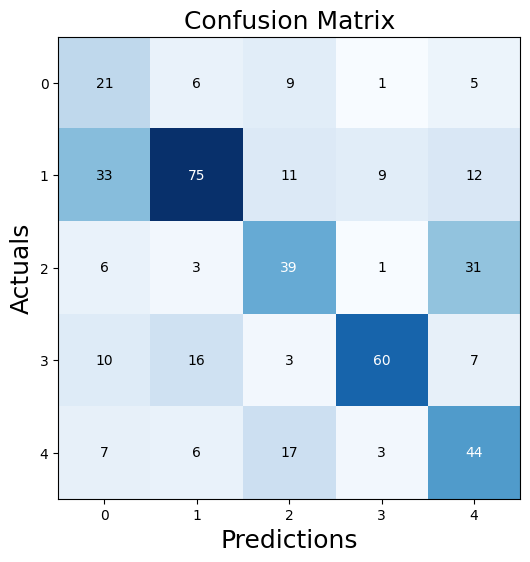

In [70]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=cm, figsize=(6, 6))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
